# Train a Hypergraph Network with Hyperedge Neurons (HNHN)

In this notebook, we will create and train a Hypergraph Network with Hyperedge Neurons in the hypergraph domain. This method is introduced in the paper [HNHN: Hypergraph Networks with Hyperedge Neurons](https://arxiv.org/abs/2006.12278) by Dong et al. We will use a benchmark dataset, CiteSeer, a collection of 1498 academic papers and 1107 authors, to do the task of node classification. There are 6 categories into which the papers are classified.

Each document is initially represented as a binary vector of length 3703, standing for a unique subset of the words within the papers, in which a value of 1 means the presence of its corresponding word in the paper.

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from topomodelx.nn.hypergraph.hnhn_layer_bis import HNHNLayer
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
from topomodelx.nn.hypergraph.hnhn import HNHN

If GPU's are available, we will make use of them. Otherwise, this will run on CPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Pre-processing

Here we download the dataset from the official repo of the paper. It contains initial representation of nodes, the incidence matrix and the category labels. The incidence matrix or $B_1$ is of shape $n_\text{nodes} \times n_\text{edges}$.

We also split the data into train and test splits according to the paper.

In [ ]:
! wget https://github.com/twistedcubic/HNHN/raw/master/data/citeseer6cls3703.pt

In [3]:
data = torch.load("citeseer6cls3703.pt")
dataset = Data(
    x=torch.from_numpy(data["paper_X"]).to(torch.float),
    incidence_1=torch.sparse_coo_tensor(
        indices=torch.LongTensor(data["paper_author"]).T,
        values=torch.ones(len(data["paper_author"]), dtype=torch.long),
    ),
    y=torch.LongTensor(data["classes"]),
)
train_test_splitter = RandomNodeSplit(num_test=0.85, num_val=0)
dataset = train_test_splitter(dataset).to(device)

# Create the Neural Network

Using the `HNHNLayer` class, we create a neural network with stacked layers.

In [5]:
class HNHN(torch.nn.Module):
    """Neural network implementation of HNHN

    Parameters
    ---------
    in_features : int
        Dimension of input features
    hidden_features : int
        Dimension of hidden features
    incidence_1: torch.sparse.Tensor
        Incidence matrix of shape [n_nodes, n_hyperedges]
    num_classes: int
        Number of classes
    n_layer : 2
        Number of HNHNLayer layers.
    dropout_rate: 0.3
    """

    def __init__(
        self,
        in_features,
        hidden_features,
        incidence_1,
        num_classes,
        n_layer=2,
        dropout_rate=0.3,
    ):
        super().__init__()
        self.to_hidden_linear = torch.nn.Linear(in_features, hidden_features)
        self.layers = torch.nn.Sequential(
            *[
                HNHNLayer(
                    hidden_features,
                    incidence_1,
                    normalization_param_alpha=-1.5,
                    normalization_param_beta=-0.5,
                )
                for _ in range(n_layer)
            ]
        )
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.to_categories_linear = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x_0):
        """Forward computation through layers.

        Parameters
        ---------
        x_0 : torch.Tensor
            Node features with shape [n_nodes, in_features]

        Returns
        --------
        y_pred : torch.Tensor
            Predicted logits with shape [n_nodes, num_classes]
        x_1: torch.Tensor
            Final hidden representation of hyperedges with shape [n_hyperedges, hidden_features]
        """
        x_1 = 0
        x_0 = self.to_hidden_linear(x_0)
        for i, layer in enumerate(self.layers):
            x_0, x_1 = layer(x_0)
            if i != len(self.layers) - 1:
                x_0, x_1 = self.dropout(x_0), self.dropout(x_1)

        return self.to_categories_linear(x_0), x_1

# Train the Neural Network

We then specify the hyperparameters and construct the model, the loss, optimizer and a LR scheduler according to the paper.

In [6]:
in_features = 3703
hidden_features = 400
num_classes = 6
n_layers = 1
dropout_rate = 0.3
initial_lr = 0.04

model = HNHN(
    in_features,
    hidden_features,
    dataset["incidence_1"],
    num_classes,
    n_layers,
    dropout_rate,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.51)

Now it's time to train the model, looping over the network for a low amount of epochs. We keep training minimal for the purpose of rapid testing.

In [7]:
train_y_true = dataset["y"][dataset["train_mask"]]
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    y_pred_logits, _ = model(dataset["x"])
    loss = loss_fn(y_pred_logits[dataset["train_mask"]], train_y_true)
    loss.backward()
    optimizer.step()
    y_pred = y_pred_logits.argmax(dim=-1)
    print(
        f"Epoch: {epoch + 1} loss: {loss.item():.4f} acc: {accuracy_score(train_y_true, y_pred[dataset['train_mask']]):.2f}"
    )
    lr_scheduler.step()

Epoch: 1 loss: 1.7841 acc: 0.21
Epoch: 2 loss: 10.6729 acc: 0.22
Epoch: 3 loss: 21.2133 acc: 0.21
Epoch: 4 loss: 35.0127 acc: 0.21
Epoch: 5 loss: 23.5536 acc: 0.23
Epoch: 6 loss: 17.4931 acc: 0.43
Epoch: 7 loss: 20.3316 acc: 0.22
Epoch: 8 loss: 12.5507 acc: 0.32
Epoch: 9 loss: 2.6564 acc: 0.49
Epoch: 10 loss: 6.0825 acc: 0.40
Epoch: 11 loss: 0.6441 acc: 0.80
Epoch: 12 loss: 1.2435 acc: 0.68
Epoch: 13 loss: 0.5326 acc: 0.84
Epoch: 14 loss: 0.3037 acc: 0.91
Epoch: 15 loss: 0.5990 acc: 0.83
Epoch: 16 loss: 0.3052 acc: 0.92
Epoch: 17 loss: 0.2278 acc: 0.93
Epoch: 18 loss: 0.2426 acc: 0.93
Epoch: 19 loss: 0.2163 acc: 0.93
Epoch: 20 loss: 0.1739 acc: 0.94
Epoch: 21 loss: 0.1618 acc: 0.93
Epoch: 22 loss: 0.1194 acc: 0.96
Epoch: 23 loss: 0.1085 acc: 0.97
Epoch: 24 loss: 0.1179 acc: 0.96
Epoch: 25 loss: 0.0925 acc: 0.97
Epoch: 26 loss: 0.0996 acc: 0.96
Epoch: 27 loss: 0.0797 acc: 0.97
Epoch: 28 loss: 0.0554 acc: 0.98
Epoch: 29 loss: 0.0584 acc: 0.98
Epoch: 30 loss: 0.0565 acc: 0.98
Epoch: 31 lo

We then evaluate the model against the test data.

In [8]:
model.eval()
with torch.no_grad():
    y_pred_logits, _ = model(dataset["x"])
test_y_true = dataset["y"][dataset["test_mask"]]
loss = loss_fn(y_pred_logits[dataset["test_mask"]], test_y_true)
print(f"Test loss: {loss.item():.4f}")
y_pred = y_pred_logits.argmax(dim=-1)
print(f"Test accuracy: {accuracy_score(test_y_true, y_pred[dataset['test_mask']]):.2f}")

Test loss: 12.1901
Test accuracy: 0.62


Finally, it's worth it to visualize the learned hidden representations after training the model.

Text(0.5, 1.0, 'Test data')

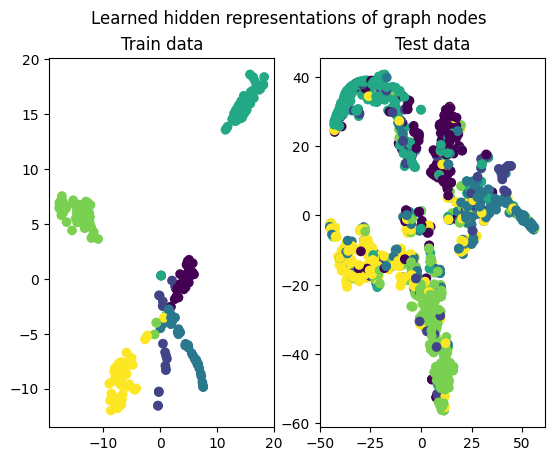

In [9]:
tsne = TSNE(n_components=2)
model.eval()
with torch.no_grad():
    x_0, _ = model.layers(model.to_hidden_linear(dataset["x"]))
x_0_train = tsne.fit_transform(x_0[dataset["train_mask"]])
x_0_test = tsne.fit_transform(x_0[dataset["test_mask"]])
f, (ax1, ax2) = plt.subplots(1, 2)
f.suptitle("Learned hidden representations of graph nodes")
ax1.scatter(x_0_train[:, 0], x_0_train[:, 1], c=dataset["y"][dataset["train_mask"]])
ax1.set_title("Train data")

ax2.scatter(x_0_test[:, 0], x_0_test[:, 1], c=dataset["y"][dataset["test_mask"]])
ax2.set_title("Test data")